Feature extractor nontrainable, <br>Last layer added according to training dataset<br>
Dataset used - Cats and Dogs<br>
TF NN - MobilNet v2<br>
plotting and predictions<br>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as dfds
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np


In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
Batch_SIZE = 16
IMG_SIZE = 224
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

In [4]:
splits = dfds.Split.ALL.subsplit(weighted=(80,20))
splits, info = dfds.load('cats_vs_dogs', with_info = True, as_supervised = True, split = splits)
(train_data, test_data)=splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [5]:
def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image/255.0
    return image, label

train_batches      = train_data.shuffle(num_examples//4).map(format_image).batch(Batch_SIZE).prefetch(1)
validation_batches = test_data.map(format_image).batch(Batch_SIZE).prefetch(1)

image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

In [6]:
feature_extractor = hub.KerasLayer(URL, input_shape = (IMG_SIZE,IMG_SIZE,3))
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)
feature_extractor.trainable = False

(16, 1280)


In [7]:
m = tf.keras.Sequential([feature_extractor,
                         layers.Dense(2, activation = 'softmax')
                        ])
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
m.compile(optimizer = 'adam',
         loss = 'sparse_categorical_crossentropy',
         metrics = ['accuracy']
         )
EPOCHS = 8
history = m.fit(train_batches,
                epochs = EPOCHS,
                verbose = 2,
               validation_data = validation_batches)

Epoch 1/8
1164/1164 - 114s - loss: 0.0470 - accuracy: 0.9844 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/8
1164/1164 - 132s - loss: 0.0294 - accuracy: 0.9900 - val_loss: 0.0596 - val_accuracy: 0.9825
Epoch 3/8
1164/1164 - 145s - loss: 0.0232 - accuracy: 0.9918 - val_loss: 0.0425 - val_accuracy: 0.9864
Epoch 4/8
1164/1164 - 178s - loss: 0.0214 - accuracy: 0.9931 - val_loss: 0.0420 - val_accuracy: 0.9858
Epoch 5/8
1164/1164 - 153s - loss: 0.0177 - accuracy: 0.9936 - val_loss: 0.0387 - val_accuracy: 0.9875
Epoch 6/8
1164/1164 - 149s - loss: 0.0156 - accuracy: 0.9944 - val_loss: 0.0522 - val_accuracy: 0.9853
Epoch 7/8
1164/1164 - 156s - loss: 0.0150 - accuracy: 0.9940 - val_loss: 0.0381 - val_accuracy: 0.9890
Epoch 8/8
1164/1164 - 130s - loss: 0.0130 - accuracy: 0.9947 - val_loss: 0.0402 - val_accuracy: 0.9881


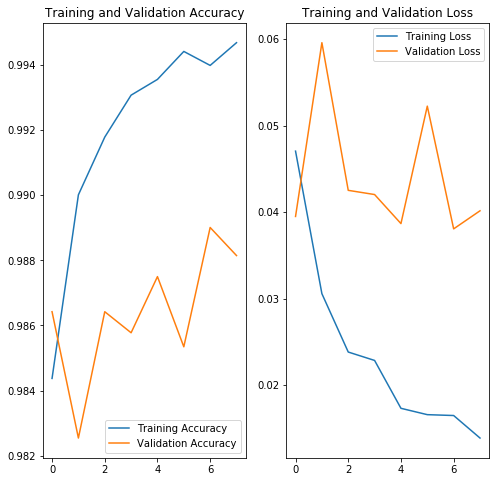

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [11]:
predicted_batch = m.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat',
       'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog'], dtype='<U3')

In [12]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1]
Predicted labels:  [0 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1]


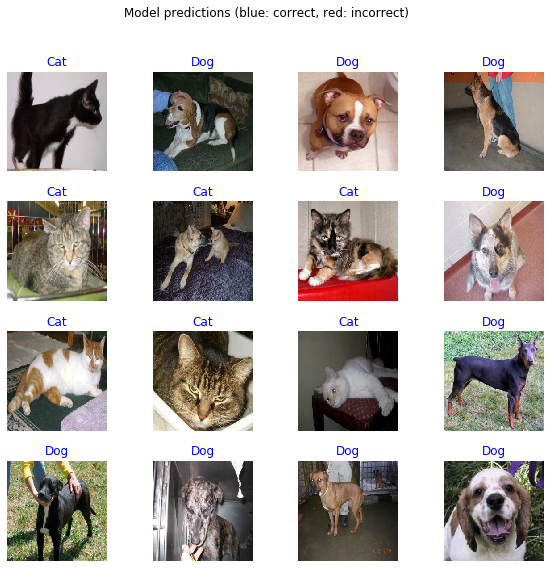

In [13]:
plt.figure(figsize=(10,9))
for n in range(16):
    plt.subplot(4,4,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")